In [1]:
import torch

def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [3]:
if IN_COLAB:
    PATH_TO_DATA = '/content/'
else:
    PATH_TO_DATA = './data/'

# Copy data 

In [5]:
BASE_PATH = '/content/drive/MyDrive/ai/detect-flood-water/'

In [6]:
!ls {BASE_PATH}

cv_results.ipynb	flood-training-metadata.csv  training_results.ipynb
detect-flood-water	flood-train-labels.tgz
flood-train-images.tgz	pth_save


In [7]:
%%time
file_name = 'flood-train-images.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 163 ms, sys: 32.8 ms, total: 195 ms
Wall time: 28.3 s


In [8]:
%%time
file_name = 'flood-train-labels.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 9.43 ms, sys: 13.6 ms, total: 23 ms
Wall time: 1.12 s


In [9]:
file_name = 'flood-training-metadata.csv'
file_path = BASE_PATH + file_name

!cp {file_path} .

# Imports

In [4]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [5]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
os.chdir("/content/drive/My Drive/ai/detect-flood-water/detect-flood-water/")

In [7]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ohrdslfd
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ohrdslfd
     |████████████████████████████████| 37.1 MB 1.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.0.3-py3-none-any.whl size=100681 sha256=8faa606a53ef794090f397af8db6e12afab7b9482492783164ddccd9fbbbe408
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7ey9wjh/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [13]:
!pip install rasterio
!pip install pandas_path
!pip install segmentation_models_pytorch

     |████████████████████████████████| 19.3 MB 91 kB/s 
     |████████████████████████████████| 87 kB 4.7 MB/s 
     |████████████████████████████████| 376 kB 22.4 MB/s 
     |████████████████████████████████| 58 kB 7.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=d40afdb29b651050581175d22f0dd579120bbdd6486ab1afe0b8b27aa6a600ec
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=9231b9b633649034de02a157a29c0093b7e0b52a594a43e3341b6a92384fb390
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [8]:
from utils import seed_everything
from dataset import FloodDataset

from plot_utils import show_image, show_image_and_label, show_train_metrics, show_loss_and_score

In [9]:
seed = 2021
seed_everything(seed)

In [10]:
import warnings

warnings.filterwarnings("ignore")

In [11]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

# Git repo 

In [120]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   data.py
	modified:   dataset.py
	modified:   detect-flood-water-train.ipynb
	modified:   main.py
	modified:   model.py
	modified:   plot_utils.py
	modified:   transform.py

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
# !git diff train.py

In [121]:
!git add .

In [122]:
!git config --global user.email "michael.kalinin.nn@gmail.com"
!git config --global user.name "michaelka"

In [123]:
!git commit -m "[colab] Testing augs. Add preprocess."

[master d7e3573] [colab] Testing augs. Add preprocess.
 7 files changed, 91 insertions(+), 5464 deletions(-)
 rewrite detect-flood-water-train.ipynb (66%)


In [124]:
!git push origin master

Counting objects: 9, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 2.42 MiB | 3.29 MiB/s, done.
Total 9 (delta 7), reused 0 (delta 0)
remote: Resolving deltas: 100% (7/7), completed with 7 local objects.
To https://github.com/MIchaelKa/detect-flood-water.git
   243f541..d7e3573  master -> master


# Load data 

In [ ]:
from pathlib import Path
from pandas_path import path
from main import get_paths_by_chip

In [ ]:
os.listdir(PATH_TO_DATA)

['.DS_Store',
 'flood-training-metadata.csv',
 'data',
 'train_features',
 'train_labels',
 'submission']

In [ ]:
train_metadata = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'flood-training-metadata.csv'),
    parse_dates=["scene_start"]
)
train_metadata.shape

(1084, 6)

In [ ]:
DATA_PATH = Path(PATH_TO_DATA)

In [ ]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

In [ ]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [ ]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start,feature_path,label_path
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15,data/train_features/awc00_vh.tif,data/train_labels/awc00.tif
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15,data/train_features/awc00_vv.tif,data/train_labels/awc00.tif
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15,data/train_features/awc01_vh.tif,data/train_labels/awc01.tif
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15,data/train_features/awc01_vv.tif,data/train_labels/awc01.tif
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15,data/train_features/awc02_vh.tif,data/train_labels/awc02.tif


In [ ]:
train_metadata.shape

(1084, 8)

In [ ]:
train_metadata = get_paths_by_chip(train_metadata)

print(len(train_metadata))
train_metadata.head()

542


,chip_id,vv_path,vh_path,flood_id
0,awc00,data/train_features/awc00_vv.tif,data/train_features/awc00_vh.tif,awc
1,awc01,data/train_features/awc01_vv.tif,data/train_features/awc01_vh.tif,awc
2,awc02,data/train_features/awc02_vv.tif,data/train_features/awc02_vh.tif,awc
3,awc03,data/train_features/awc03_vv.tif,data/train_features/awc03_vh.tif,awc
4,awc04,data/train_features/awc04_vv.tif,data/train_features/awc04_vh.tif,awc


In [ ]:
flood_ids = train_metadata.flood_id.unique().tolist()
flood_ids

['awc',
 'ayt',
 'coz',
 'hbe',
 'hxu',
 'jja',
 'kuo',
 'pxs',
 'qus',
 'qxb',
 'tht',
 'tnp',
 'wvy']

In [ ]:
exclude_flood_ids = ['hxu', 'coz']
train_metadata = train_metadata[~train_metadata.flood_id.isin(exclude_flood_ids)]

In [ ]:
print(len(train_metadata))

488


In [ ]:
flood_ids = train_metadata.flood_id.unique().tolist()
flood_ids, len(flood_ids)

(['awc', 'ayt', 'hbe', 'jja', 'kuo', 'pxs', 'qus', 'qxb', 'tht', 'tnp', 'wvy'],
 11)

# Split data

In [ ]:
import random
from main import get_paths_by_chip

In [ ]:
# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids = ['qus', 'hxu', 'pxs']
val_flood_ids = ['kuo', 'tht', 'qus']
val_flood_ids

['kuo', 'tht', 'qus']

In [ ]:
valid_df = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train_df = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

In [ ]:
# Separate features from labels
val_x = get_paths_by_chip(valid_df)
val_y = valid_df[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train_df)
train_y = train_df[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [ ]:
len(val_x) / (len(val_x) + len(train_x)) * 100

23.062730627306273

 # Dataset

In [12]:
from data import prepare_data, get_dataset
from plot_utils import show_dataset

In [13]:
reduce_train = False
train_number = 32
valid_number = 32

# seed = 2022
seed_everything(seed)

train_x, train_y, val_x, val_y = prepare_data(PATH_TO_DATA, reduce_train, train_number, valid_number)

[data] flood_ids: ['kuo', 'tht', 'qus']
[data] Dataset size, train: 417, valid: 125, ratio: 23.062730627306273


In [16]:
train_x.head()

,chip_id,vv_path,vh_path,flood_id
0,awc00,/content/train_features/awc00_vv.tif,/content/train_features/awc00_vh.tif,awc
1,awc01,/content/train_features/awc01_vv.tif,/content/train_features/awc01_vh.tif,awc
2,awc02,/content/train_features/awc02_vv.tif,/content/train_features/awc02_vh.tif,awc
3,awc03,/content/train_features/awc03_vv.tif,/content/train_features/awc03_vh.tif,awc
4,awc04,/content/train_features/awc04_vv.tif,/content/train_features/awc04_vh.tif,awc


In [14]:
train_dataset, valid_dataset = get_dataset(
    PATH_TO_DATA,
    reduce_train,
    train_number,
    valid_number
)

[data] flood_ids: ['kuo', 'tht', 'qus']
[data] Dataset size, train: 417, valid: 125, ratio: 23.062730627306273


[0 1 2 3 4]


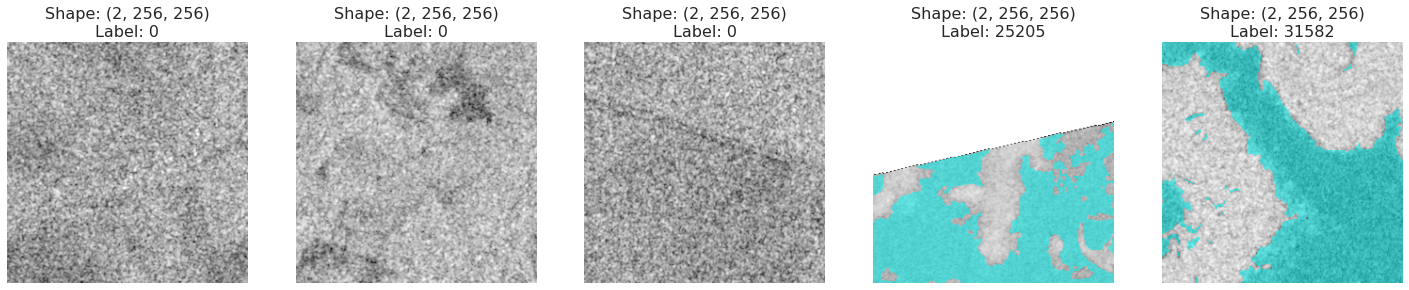

In [15]:
show_dataset(train_dataset, 0, 5)

In [58]:
train_dataset_orig = FloodDataset(train_x, train_y, transforms=None)

[5 6 7 8 9]


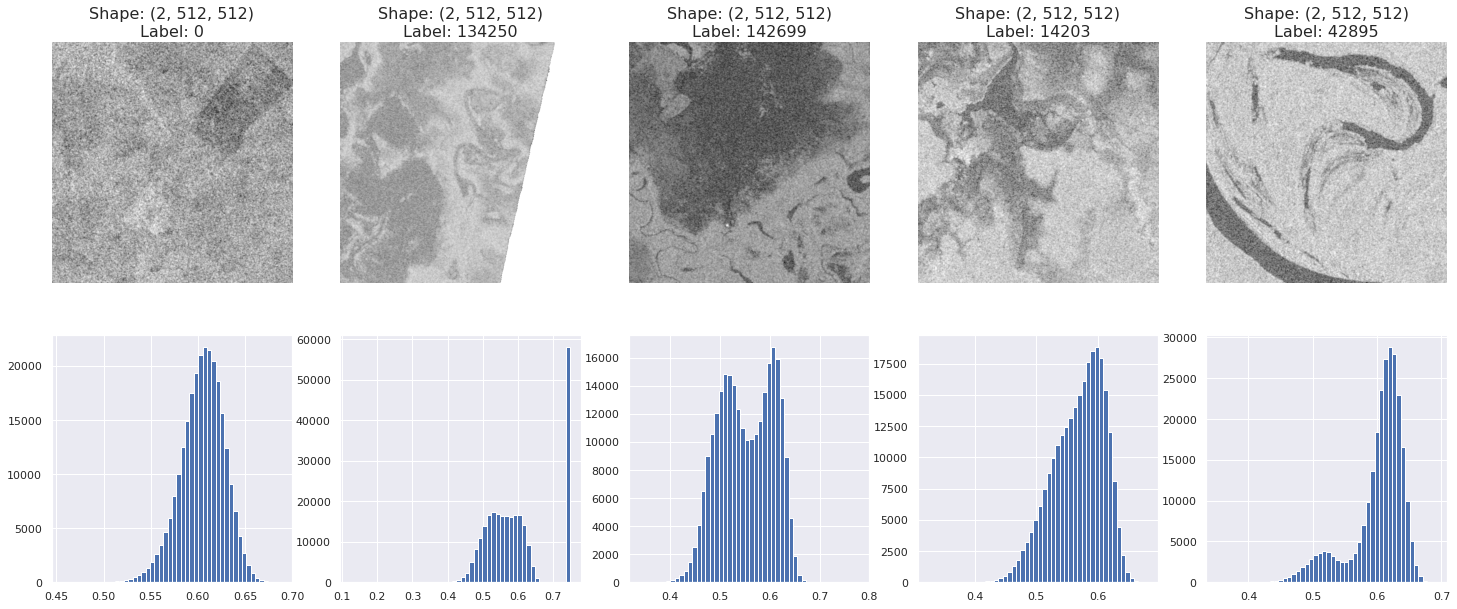

In [76]:
show_dataset(train_dataset_orig, 5, 5, show_mask=False, show_hist=True)

In [19]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(train_dataset_orig) // 5,
    step=1,
    description='Index:',
    disabled=False
)

def handle_change(x):
    show_dataset(train_dataset_orig, x*5, 5)

In [ ]:
from transform import get_train_transform

In [20]:
import albumentations as A

In [54]:
class InvertScaledImg(A.ImageOnlyTransform):
    def apply(self, img, **params):
        return 1 - img

    def get_transform_init_args_names(self):
        return ()

In [84]:
limit_single = -0.3

def get_train_transform(crop_size):
    transform = A.Compose([
#         A.RandomCrop(crop_size, crop_size),

        # A.ChannelShuffle()

        # InvertScaledImg()
        
        #
        # Color
        #
        
        # A.RandomBrightness(
        #     limit=(limit_single,limit_single),
        #     p=1
        # )
        
        # A.RandomBrightnessContrast(
        #     brightness_limit=0,
        #     contrast_limit=(limit_single,limit_single),
        #     p=1
        # ),
        
        # A.CLAHE(p=1),
        
        #
        # Geometric
        #

        A.OneOf([
            A.RandomRotate90(),
            A.Compose([
                A.HorizontalFlip(),
                A.VerticalFlip(),           
            ])
        ], p=0.75),
        
#         A.RandomRotate90(),
#         A.HorizontalFlip(),
#         A.VerticalFlip(),

        
#         A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
        
        
        # distort_limit=0.5
#         A.GridDistortion(
#             num_steps=5,
#             distort_limit=0.3,
# #             border_mode=0,
#             p=1
#         )
        
        # distort_limit=(1,1)
        # A.OpticalDistortion(
        #     distort_limit=(0,1),
        #     shift_limit=0.5,
        #     # border_mode=0,
        #     p=1
        # )
        
        
#         A.RandomSizedCrop(
#             min_max_height=(50, 512),
#             height=crop_size,
#             width=crop_size,
#             p=1
#         )

    ])
    return transform

In [88]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn, get_preprocessing_params

encoder_name = 'timm-efficientnet-b0'

preprocess_input = get_preprocessing_fn(encoder_name, pretrained='imagenet')
preprocessing = A.Lambda(image=preprocess_input)

In [94]:
params = get_preprocessing_params(encoder_name, pretrained='imagenet')
params['mean'] = params['mean'][:2]
params['std'] = params['std'][:2]
params

{'input_range': (0, 1),
 'input_space': 'RGB',
 'mean': (0.485, 0.456),
 'std': (0.229, 0.224)}

In [95]:
def preprocess_input(x, mean=None, std=None, **kwargs):

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

In [98]:
import functools

def get_preprocessing_fn(encoder_name, pretrained="imagenet"):
    params = get_preprocessing_params(encoder_name, pretrained=pretrained)
    params['mean'] = params['mean'][:2]
    params['std'] = params['std'][:2]
    return functools.partial(preprocess_input, **params)

In [99]:
preprocess_input = get_preprocessing_fn(encoder_name, pretrained='imagenet')
preprocessing = A.Lambda(image=preprocess_input)

In [23]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Index:', max=83), Output()), _dom_classes=('widget-…

<function __main__.handle_change>

In [100]:
crop_size = 256
transforms=get_train_transform(crop_size)
train_dataset = FloodDataset(
    train_x,
    train_y,
    transforms=transforms,
    preprocessing=preprocessing
)

In [101]:
print(transforms)

Compose([
  OneOf([
    RandomRotate90(always_apply=False, p=0.5),
    Compose([
      HorizontalFlip(always_apply=False, p=0.5),
      VerticalFlip(always_apply=False, p=0.5),
    ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
  ], p=0.75),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


[5 6 7 8 9]


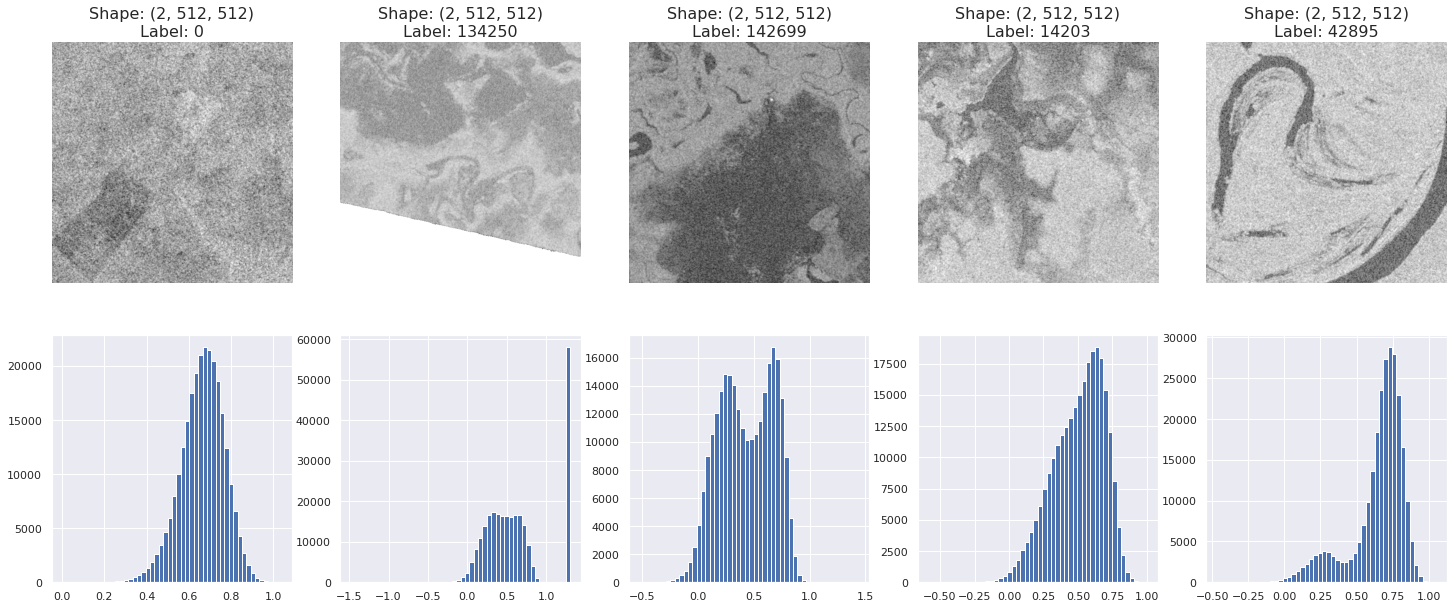

In [103]:
start_index = 1
show_dataset(train_dataset, start_index*5, 5, show_mask=False, show_hist=True)

In [ ]:
sample_data = train_dataset[0]
chip = sample_data['chip']
label = sample_data['label']

chip.shape, label.shape

((2, 256, 256), (256, 256))

In [ ]:
label_to_show = np.ma.masked_where((label == 0) | (label == 255), label)

In [ ]:
256*256

65536

In [ ]:
(1 - label_to_show.mask).sum()

0

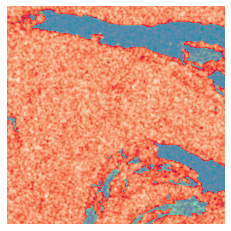

In [ ]:
label_to_show = np.ma.masked_where((label == 0) | (label == 255), label)
show_image_and_label(chip[1], label_to_show)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)
len(train_loader)

14

In [ ]:
%%time
for i, x in enumerate(train_loader):
    pass

CPU times: user 12.1 s, sys: 788 ms, total: 12.8 s
Wall time: 12.8 s


# Scheduler and Optimizer

In [ ]:
from main import get_scheduler, test_scheduler
from model import get_model

In [ ]:
encoder_name = 'resnet18'
model = get_model(encoder_name)

In [ ]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
len(list(model.encoder.parameters()))

60

In [ ]:
parameters = [
    {'params': model.encoder.parameters(), 'lr': 1e-3},
    {'params': model.decoder.parameters(), 'lr': 2e-3}
]

optimizer = torch.optim.SGD(
    parameters,
    lr=3e-3,
    momentum=0.9,
    weight_decay=0,
    nesterov=True
)

In [ ]:
scheduler_params = dict(
    name = 'OneCycleLR', # MultiStepLR OneCycleLR None

    # MultiStepLR
#     milestones = [1, 50, 200],
#     gamma = 0.4,
    
    # OneCycleLR
    max_lr = [0.03, 0.04],
    pct_start = 0.3,
)

In [ ]:
max_iter = 300
scheduler = get_scheduler(optimizer, max_iter, scheduler_params)

In [ ]:
lr_history = []
# lr_history = []

for epoch in range(max_iter):
    optimizer.step()
    lr_history.append(scheduler.get_last_lr())
    scheduler.step()

In [ ]:
len(optimizer.param_groups)

2

In [ ]:
len(optimizer.param_groups[0]['params'])

60

In [ ]:
len(optimizer.param_groups[1]['params'])

30

In [ ]:
optimizer.param_groups[0]['initial_lr'], 0.03/25

(0.0012, 0.0012)

In [ ]:
learning_rate = 0.001
max_iter = 300
scheduler_params

{'name': 'MultiStepLR', 'milestones': [1, 50, 200], 'gamma': 0.4}

In [ ]:
lr_history = test_scheduler(learning_rate, max_iter, scheduler_params)

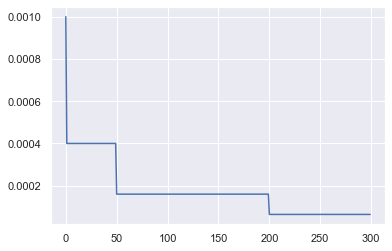

In [ ]:
plt.plot(lr_history)

# Memory

In [ ]:
from utils import display_memory, get_num_of_params
from train import set_encoder_grad

In [ ]:
display_memory(device)
X = torch.randn(32, 2, 256, 256).to(device)
display_memory(device) # 32*2*256*256*4 / 1024 ** 3

0.291 GB
0.306 GB


In [ ]:
32*2*256*256*4 / 1024 ** 3

0.015625

In [ ]:
%%time

display_memory(device)

model = get_model().to(device)
# set_encoder_grad(model, False)

output = model(X)
print(output.shape)

display_memory(device)
del output
display_memory(device)

0.330 GB
torch.Size([32, 2, 256, 256])
6.195 GB
0.309 GB
CPU times: user 235 ms, sys: 23.3 ms, total: 259 ms
Wall time: 258 ms


In [ ]:
get_num_of_params(model)

8756962

In [ ]:
# model

## Single model pass

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
encoder_name = 'resnet18'
encoder_weights = 'imagenet'

model = smp.DeepLabV3(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=2,
    classes=2,
)

In [ ]:
decoder_channels = 256
model.decoder = smp.deeplabv3.decoder.DeepLabV3Decoder(
    in_channels=model.encoder.out_channels[-1],
    out_channels=decoder_channels,
    atrous_rates=(6, 8, 12)
)

In [ ]:
# model

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
train_loader_iter = iter(train_loader)

In [ ]:
data_dict = next(train_loader_iter)

id_batch = data_dict['chip_id']
x_batch = data_dict['chip'].to(device)
y_batch = data_dict['label'].to(device)

x_batch.shape, y_batch.shape

(torch.Size([4, 2, 256, 256]), torch.Size([4, 256, 256]))

In [ ]:
output = model.encoder(x_batch)

In [ ]:
len(output)

6

In [ ]:
for o in output:
    print(o.shape)

torch.Size([4, 2, 256, 256])
torch.Size([4, 64, 128, 128])
torch.Size([4, 64, 64, 64])
torch.Size([4, 128, 32, 32])
torch.Size([4, 256, 32, 32])
torch.Size([4, 512, 32, 32])


In [ ]:
output = model(x_batch)
print(output.shape)

torch.Size([4, 2, 256, 256])


In [ ]:
from loss import XEDiceLoss

In [ ]:
# loss = smp.utils.losses.DiceLoss()
loss = nn.CrossEntropyLoss(ignore_index=255)

In [ ]:
y_batch = y_batch.type(torch.long)
# y_batch = y_batch.unsqueeze(1)
loss_value = loss(output, y_batch)
loss_value

tensor(0.6939, grad_fn=<NllLoss2DBackward>)

In [ ]:
loss = XEDiceLoss()

In [ ]:
loss_value = loss(output, y_batch)
loss_value

tensor(0.7426, device='cuda:0', grad_fn=<AddBackward0>)

# Run

In [38]:
from main import run, get_model
from plot_utils import show_valid_score_by_flood

In [39]:
# timm-efficientnet-b0, efficientnet-b0, resnet18, resnet34, se_resnext50_32x4d
encoder_name = 'timm-efficientnet-b0'
model_name = 'unet'

In [40]:
# TODO: one LR field in params

encoder_lr = 3e-2
decoder_lr = 3e-1

max_lr = [encoder_lr, decoder_lr, decoder_lr]
# max_lr = [decoder_lr]

In [41]:
scheduler_params = dict(
    name = 'None', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [300],
    gamma = 0.4,
    
    # OneCycleLR
    max_lr = max_lr,
    pct_start = 0.3,
)

### Debug training

In [ ]:
# scheduler_params = dict(
#     name = 'MultiStepLR', # MultiStepLR OneCycleLR None

#     # MultiStepLR
#     milestones = [1, 2, 3],
#     gamma = 0.5,
# )

debug_params = dict(
    reduce_train=True,
    train_number=20,
    valid_number=4,

    batch_size_train=2,
    batch_size_valid=2,
    max_iter=5,
    valid_iters=[1, 3, 4],
    unfreeze_iter=0,
    
    scheduler_params=scheduler_params,
    
    save_model=False,
)

In [ ]:
small_dataset_params = dict(
    reduce_train=True,
    train_number=32,
    valid_number=16,

    batch_size_train=4,
    batch_size_valid=4,
    max_iter=200,
    valid_iters=[10, 50, 100, 150, 199],
    
    save_model=False,
)

### Full training

In [42]:
num_train_samples = 9600
batch_size_train = 16

max_iter = num_train_samples // batch_size_train
num_train_samples = batch_size_train * max_iter

max_iter, num_train_samples

(600, 9600)

In [43]:
# max_iter=300
# valid_iters=[50, 100, 150, 200, 250, 299]

# max_iter=100
# valid_iters=[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]

max_iter=480
valid_step=30
unfreeze_iter=0 # 90

valid_iters = list(np.arange(valid_step-1, max_iter, valid_step))
valid_iters

[29, 59, 89, 119, 149, 179, 209, 239, 269, 299, 329, 359, 389, 419, 449, 479]

In [44]:
full_params = dict(
    reduce_train=False,
    train_number=0,
    valid_number=0,

    batch_size_train=32,
    batch_size_valid=32,
    max_iter=max_iter,
    unfreeze_iter=unfreeze_iter,
#     valid_iters=valid_iters
    
    scheduler_params=scheduler_params,
    
    save_model=True,
    model_save_name=f'{model_name}_{encoder_name}_V1_13.09'
)

In [105]:
params = dict(
    path_to_data=PATH_TO_DATA,

    optimizer_name='Adam', # SGD, Adam, AdamW
    learning_rate=3e-4, # 5e-4, 3e-4, 1e-3
    # learning_rate=[3e-5, 3e-4],
    weight_decay=0,
    dice_ratio=0,

    verbose=True
)

params.update(full_params) # full_params, debug_params, small_dataset_params

In [106]:
params

{'batch_size_train': 32,
 'batch_size_valid': 32,
 'dice_ratio': 0,
 'learning_rate': 0.0003,
 'max_iter': 480,
 'model_save_name': 'unet_timm-efficientnet-b0_V1_13.09',
 'optimizer_name': 'Adam',
 'path_to_data': '/content/',
 'reduce_train': False,
 'save_model': True,
 'scheduler_params': {'gamma': 0.4,
  'max_lr': [0.03, 0.3, 0.3],
  'milestones': [300],
  'name': 'None',
  'pct_start': 0.3},
 'train_number': 0,
 'unfreeze_iter': 0,
 'valid_number': 0,
 'verbose': True,
 'weight_decay': 0}

In [107]:
other_params = dict(
    valid_iters=valid_iters,
#     scheduler_params=scheduler_params
)
params.update(other_params)

In [116]:
seed = 2021
seed_everything(seed)

model = get_model(encoder_name).to(device)

train_info = run(model, device, **params)

[run]
[data] flood_ids: ['kuo', 'tht', 'qus']
[data] Dataset size, train: 417, valid: 125, ratio: 23.062730627306273

[data] train_transform:
Compose([
  RandomCrop(always_apply=False, p=1.0, height=256, width=256),
  RandomRotate90(always_apply=False, p=0.5),
  HorizontalFlip(always_apply=False, p=0.5),
  VerticalFlip(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


[data] preprocessing:
{'input_space': 'RGB', 'input_range': (0, 1), 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225)}

[data] DataLoader size, train: 14, valid: 4
[data] num_epoch: 34.285714285714285, num_train_samples: 15360
[train] started...
[train] iter:   29, loss = 0.43573, score = 0.38903, time: 0:00:43
[valid] iter:   29, loss = 0.35762, score = 0.40853, time: 0:00:43
[valid] iter:   29, score = {'kuo': 0.07041134685277939, 'qus': 0.7448493838310242, 'tht': 0.6419787406921387}

[train] iter:   59, loss = 0.33436, score = 0.48934, time: 0:01:26
[valid]

In [49]:
# model

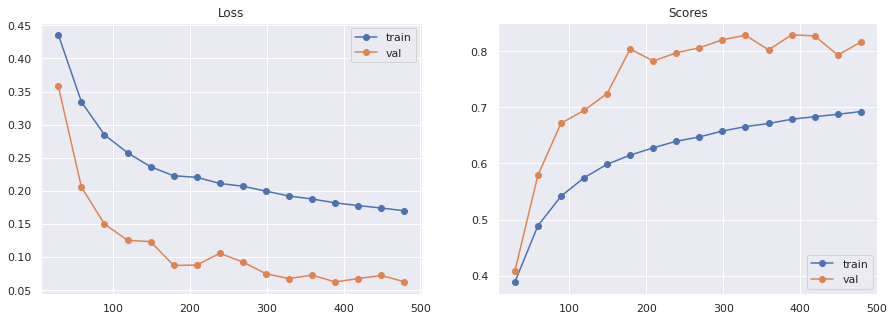

In [117]:
# show_loss_and_score(train_info, start_from=1)
show_loss_and_score(train_info)

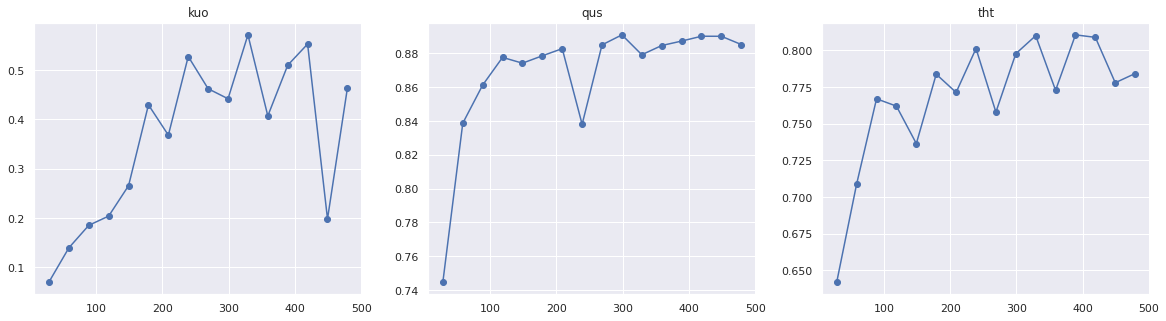

In [119]:
show_valid_score_by_flood(train_info)

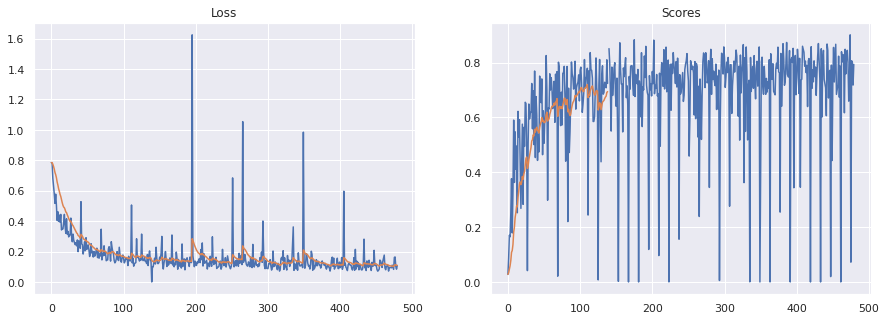

In [114]:
loss_meter = train_info['train_loss_meter']
score_meter = train_info['train_score_meter']
show_train_metrics(loss_meter, score_meter)

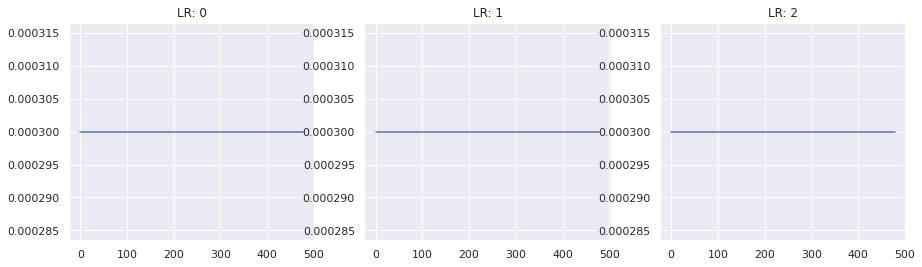

In [36]:
lr_s = list(zip(*train_info['lr_history']))
num_lr_s = len(lr_s)
_, axes = plt.subplots(1, num_lr_s, figsize=(num_lr_s*5,4))
for i in range(num_lr_s):
    axes[i].set_title(f'LR: {i}')
    axes[i].plot(lr_s[i])

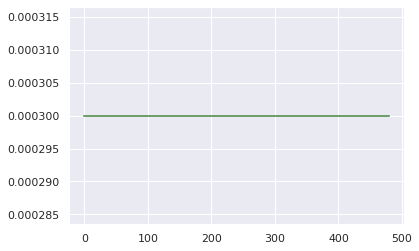

In [37]:
plt.plot(train_info['lr_history'])

# Validation 

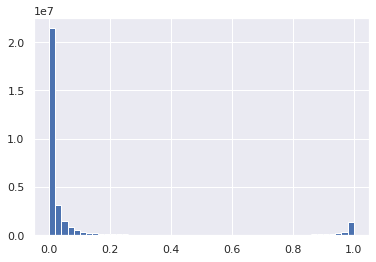

In [115]:
# TODO: pick threshold using this plot
valid_outputs = train_info['valid_outputs']
# len(valid_outputs), valid_outputs[0].shape, 512*512*32
plt.hist(np.concatenate(valid_outputs), bins=50)
plt.show()

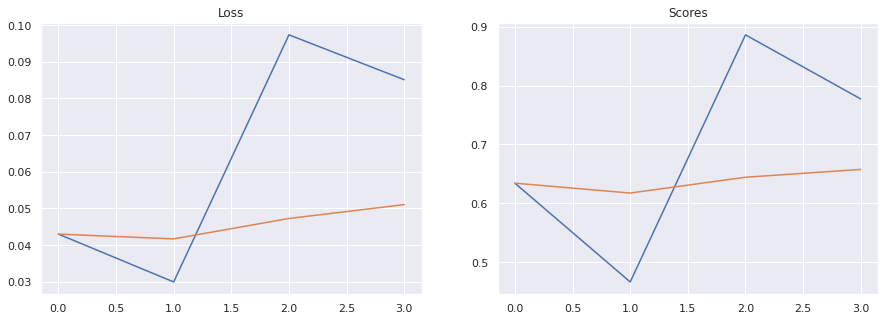

In [39]:
loss_meter = train_info['valid_loss_meter']
score_meter = train_info['valid_score_meter']
show_train_metrics(loss_meter, score_meter)

In [ ]:
from dataset import FloodDataset
from main import get_data_by_flood_id
from train import validate

In [ ]:
# model = get_model().to(device)

In [ ]:
# valid_dataset = train_info['valid_dataset']

flood_id = 'hxu' # qus kuo hxu
val_x, val_y = get_data_by_flood_id(PATH_TO_DATA, flood_id)
valid_dataset = FloodDataset(val_x, val_y, transforms=None)

[data] Dataset size: 26


In [ ]:
loss = nn.CrossEntropyLoss(ignore_index=255)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
loss_meter, score_meter, outputs = validate(model, device, valid_loader, loss, print_every=1)

[valid] iter:    0, loss = 0.16806, score = 0.28734, time: 0:00:07
[valid] iter:    1, loss = 0.18635, score = 0.27321, time: 0:00:14
[valid] iter:    2, loss = 0.18158, score = 0.30804, time: 0:00:21
[valid] iter:    3, loss = 0.17597, score = 0.29807, time: 0:00:23


In [ ]:
# show_train_metrics(loss_meter, score_meter)

In [ ]:
score_meter.compute_score()

tensor(0.2981)

In [ ]:
score_meter.intersection, score_meter.union

(tensor(196529), tensor(352819))

# Show predictions

In [ ]:
os.listdir('pth')

['unet_timm-efficientnet-b0_v3.pth',
 'unet_timm-efficientnet-b0_v2_389.pth',
 'unet_timm-efficientnet-b0_V2_10.09.pth']

In [ ]:
model = get_model().to(device)

In [ ]:
model_path = 'pth/unet_timm-efficientnet-b0_V2_10.09.pth'
# model.load_state_dict(torch.load(model_path))
model.load_state_dict(torch.load(model_path, map_location='cpu'))

model = model.eval()
# model = model.train()

In [ ]:
# valid_dataset = train_info['valid_dataset']
len(valid_dataset)

26

In [ ]:
valid_sample = valid_dataset[1]

chip = valid_sample['chip']
label = valid_sample['label']

chip.shape, label.shape

((2, 512, 512), (512, 512))

In [ ]:
def create_fcc_dataset_sample(s1_img):
    s1_img = np.transpose(s1_img, [1, 2, 0])
    
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    
    b_channel = s1_img[:, :, 0] / s1_img[:, :, 1]
    bc_max = b_channel.max()
    bc_min = b_channel.min()
    b_channel = (b_channel - bc_min) / (bc_max - bc_min)       
    img[:, :, 2] = b_channel

    return img

In [ ]:
fcc = create_fcc_dataset_sample(chip)
fcc.shape

(512, 512, 3)

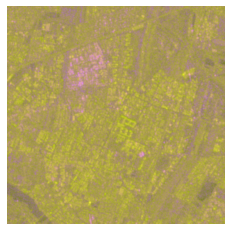

In [ ]:
show_image(fcc)

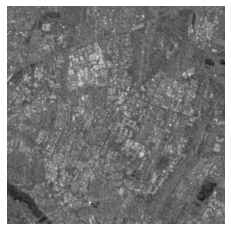

In [ ]:
show_image(fcc[:,:,0], cmap='gray')

In [ ]:
# plt.hist(chip[0].reshape(-1), bins=50)

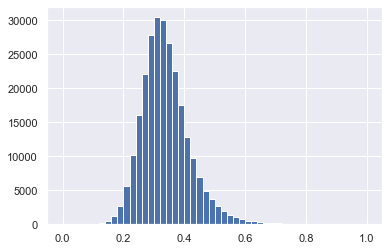

In [ ]:
plt.hist(fcc[:,:,2].reshape(-1), bins=50)
plt.show()

In [ ]:
from metrics import IoUMeter
from train import compute_prediction
from plot_utils import show_predictions, get_chip_by_id

In [ ]:
meter = IoUMeter()

In [ ]:
def get_prediction(model, chip, label):
    chip = torch.tensor(chip).unsqueeze(0).to(device)
    # mask = torch.tensor(mask).to(device)
    label = torch.tensor(label).to(device)
    
    output = model(chip)
    pred = compute_prediction(output).squeeze()
        
    iou, inter, union = meter.update(pred, label)
    print(f'IoU: {iou:.5f}, inter: {inter}, union: {union}')
    print(f'Total IoU: {meter.compute_score():.5f}')
    
    return pred

In [ ]:
def get_and_show_predictions(index, model, valid_dataset):    
    valid_sample = valid_dataset[index]
    
    chip_id = valid_sample['chip_id']  
    chip_to_show = get_chip_by_id(chip_id, train_metadata)
    print(f'Chip: {chip_id}')
    
    label = valid_sample['label']  
    label_to_show = np.ma.masked_where((label == 0) | (label == 255), label)
    
    label_sum = (1 - label_to_show.mask).sum()
    print(f'Label: {label_sum}')
    
    chip = valid_sample['chip']
    pred = get_prediction(model, chip, label).cpu()
    pred_to_show = np.ma.masked_where(pred == 0, pred)
    
    show_predictions(chip_to_show, chip, label_to_show, pred_to_show)

In [ ]:
# np.array(meter.history).mean()

Chip: hxu01
Label: 28395
IoU: 0.24431, inter: 12962, union: 53056
Total IoU: 0.24431


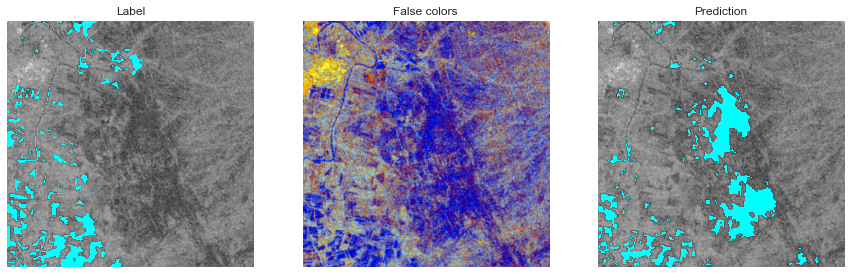

In [ ]:
index = 1 # 4 19
meter.reset()
get_and_show_predictions(index, model, valid_dataset)

IoU: 0.0 
Total IoU: 0.0


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


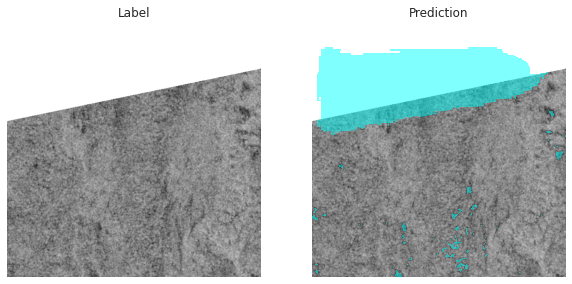

In [ ]:
index = 19
meter.reset()
get_and_show_predictions(index, model, valid_dataset)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [ ]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(valid_dataset)-1,
    step=1,
    description='Index:',
    disabled=False
)

def handle_change(x):
    get_and_show_predictions(x, model, valid_dataset)

In [ ]:
meter.reset()
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Index:', max=25), Output()), _dom_classes=('widget-…

<function __main__.handle_change(x)>

In [ ]:
Inspecting prediction on hxu

unet_timm-efficientnet-b0_V2_10.09.pth

- a lot of false positives as expected

In [ ]:
Inspecting prediction on kuo

9.09 unet_timm-efficientnet-b0_v2_389

- small details unlikely affects us?
- when detecting a lot of water the metric goes up very quickly (kuo12)
- bright red areas hardly distinguishable at VV VH images (kuo47)

- false positive predictions
- detecting what we call "bad labeling" (kuo14)
- detecting bright red areas (kuo17, kuo19, kuo47)

- do not fill label completely
- do not detecting big water with small red dots (kuo06)
- bad at predicting rivers